In [70]:
import sys
sys.path.append('..')

from utills import tsne_functions
from utills import tsne_multiprocess
import Functions_thesis as F



import numpy as np
import pandas as pd
import FlowCal
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from fcsy import DataFrame
from PIL import Image
from tqdm import tqdm
import time
from tqdm.notebook import tqdm_notebook
import PIL
import torch
import torch.nn as nn 
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch
from torch.utils.data import Dataset

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from openTSNE import TSNE
import torchvision.models as models
import sklearn.metrics as metrics

import importlib



In [231]:
# Path to the datasets
path='../Datasets/'
file_path_nkcell_train=os.path.join(path,'NK_cell-2/train')
file_path_nkcell_test=os.path.join(path,'NK_cell-2/test')

In [232]:
# Make a list of some of the features that are not relevant and that hinders the models performance and remove them  
drop=['(Ir191)Dd', '(Ir193)Dd','(In115)Dd', '(La139)Dd','Time', 'Cell_length']

# Sampling cells

- We sample a fixed amount of cells from all the patients and form a dataframe.
- This sampled dataframe will be used to fit our embedding techniques.

- Instead of applying the embedding techniques and fitting them to each patient we do it on a subsampled data of all patients.
- So this subsampled data will contributions from all patients and then we can fit the embedding technique on it.


In [233]:
df_1k_train=F.sampled_cells_tsne(file_path_nkcell_train,5000,drop)

100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 17.10it/s]


# Min Max Scaling

- We apply here tsne embedding and get the min and max for each patient.
- This min and max for each patient is saved to a dataframe.
- Than a global min and max is obtained for the whole dataset.
- This way we ensure that all the 2d histplots created would have the same x and y axis limits.
- Making the data standardized.

In [234]:
F.min_max_tsne_multiprocess(df_1k_train,file_path_nkcell_train,drop)

100%|████████████████████████████████████████| 15/15 [00:00<00:00, 23147.37it/s]


(-73.83141165532892, 85.80558945297798, -69.62740527003547, 81.93167451181114)

# Generate 2d Histograms

- After getting the min and max for both the axis.
- We generate 2d histograms for the data.

In [241]:
nk_tsne_256=F.tsne_2darrays(file_path_nkcell_train,df_1k_train,-73.83141165532892, 85.80558945297798,
                            -69.62740527003547, 81.93167451181114,100,256,drop)

In [242]:
nk_tsne_256_test=F.tsne_2darrays(file_path_nkcell_test,df_1k_train,-73.83141165532892, 85.80558945297798,
                                 -69.62740527003547, 81.93167451181114,100,256,drop)

In [253]:
nk_tsne_256.head()

,hist_array,fcs_file
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",a_012_NK.fcs
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",a_4a_NK.fcs
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",a_2b_NK.fcs
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",a_3b_NK.fcs
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",a_5a_NK.fcs


# Visualizing the data 

In [295]:
# drawing the visualizations
def draw_subplots(dataframe, col_name='hist_array', num_cols=7, figsize=(15,15)):
    """
    Draw subplots for each element in the specified column of a DataFrame.

    Parameters:
    - dataframe: DataFrame containing the data
    - col_name: Name of the column to extract from the DataFrame (default is 'hist_array')
    - num_cols: Number of subplots per row (default is 3)
    - figsize: Size of the overall figure (default is (15, 5))
    """

    num_plots = len(dataframe)

    # Set the number of rows for subplots
    num_rows = (num_plots + num_cols - 1) // num_cols

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    # Flatten the axes array for easy indexing
    axes = axes.flatten()

    for i in range(num_plots):
        # Create subplot
        axes[i].imshow(dataframe[col_name][i])

        # Customize subplot title, if needed
        axes[i].set_title('Label = {}'.format(dataframe['label'][i]))

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Show the plot
    plt.show()




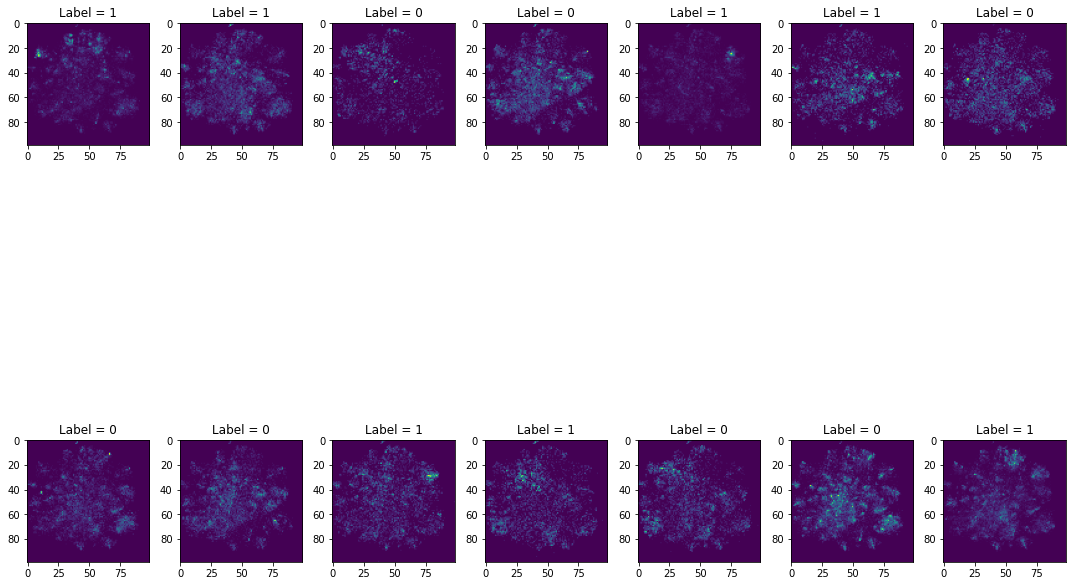

In [300]:
draw_subplots(df_train_nk)

# Combining the labels with the 2d arrays

In [256]:
nk_label_train=pd.read_csv(os.path.join(file_path_nkcell_train,'train_labels.csv'))
nk_label_train.rename(columns = {'fcs_filename':'fcs_file'}, inplace = True)

In [257]:
nk_label_test=pd.read_csv(os.path.join(file_path_nkcell_test,'test_labels.csv'))
nk_label_test.rename(columns = {'fcs_filename':'fcs_file'}, inplace = True)

In [258]:
df_train_nk = pd.merge(nk_tsne_256, nk_label_train, on='fcs_file')
df_test_nk = pd.merge(nk_tsne_256_test, nk_label_test, on='fcs_file')

# Data Loaders

In [259]:
# Creating dataset objects from the image data
Training_data=F.CustomDataset(df_train_nk)
Test_data=F.CustomDataset(df_test_nk)

# Convert the dataset objects to dataloaders
Training_dataloader= torch.utils.data.DataLoader(dataset=Training_data,batch_size=13,
                                                 shuffle=True)
Test_dataloader= torch.utils.data.DataLoader(dataset=Test_data,batch_size=6)

In [260]:
model=F.CNN()
cnn_trained_256=F.train_model(Training_dataloader,0.001,50,model)

Epoch [1/50] Loss: 0.7985
Epoch [2/50] Loss: 0.5672
Epoch [3/50] Loss: 0.5411
Epoch [4/50] Loss: 1.1552
Epoch [5/50] Loss: 0.5853
Epoch [6/50] Loss: 0.5513
Epoch [7/50] Loss: 0.5435
Epoch [8/50] Loss: 0.6787
Epoch [9/50] Loss: 0.6141
Epoch [10/50] Loss: 0.5575
Epoch [11/50] Loss: 0.5739
Epoch [12/50] Loss: 0.5476
Epoch [13/50] Loss: 0.4857
Epoch [14/50] Loss: 0.4738
Epoch [15/50] Loss: 0.3994
Epoch [16/50] Loss: 0.3506
Epoch [17/50] Loss: 0.3077
Epoch [18/50] Loss: 0.6042
Epoch [19/50] Loss: 0.2348
Epoch [20/50] Loss: 0.2470
Epoch [21/50] Loss: 0.1336
Epoch [22/50] Loss: 0.1130
Epoch [23/50] Loss: 0.1362
Epoch [24/50] Loss: 0.0585
Epoch [25/50] Loss: 0.0643
Epoch [26/50] Loss: 0.0797
Epoch [27/50] Loss: 0.0964
Epoch [28/50] Loss: 0.0701
Epoch [29/50] Loss: 0.0228
Epoch [30/50] Loss: 0.0683
Epoch [31/50] Loss: 0.0421
Epoch [32/50] Loss: 0.0161
Epoch [33/50] Loss: 0.0120
Epoch [34/50] Loss: 0.0075
Epoch [35/50] Loss: 0.0165
Epoch [36/50] Loss: 0.0048
Epoch [37/50] Loss: 0.0038
Epoch [38/

Accuracy: 83.33%
AUC: 1.00


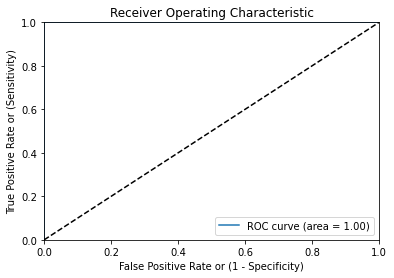

In [261]:
F.evaluate_model(Test_dataloader,cnn_trained_256)

In [262]:
F.Confusion_matrix(Test_dataloader,cnn_trained_256)

Confusion_matrix:   0%|          | 0/1 [00:00<?, ?it/s]

array([[3, 1],
       [0, 2]])

## Resnet18 Pre_trained = Fallse (overfits)

In [153]:
model=F.ModifiedCNN()
resnet_trained_256=F.train_model(Training_dataloader,0.001,50,model)

Epoch [1/50] Loss: 1.0061
Epoch [2/50] Loss: 0.1754
Epoch [3/50] Loss: 1.3901
Epoch [4/50] Loss: 0.4678
Epoch [5/50] Loss: 0.6353
Epoch [6/50] Loss: 0.5715
Epoch [7/50] Loss: 0.5012
Epoch [8/50] Loss: 0.2526
Epoch [9/50] Loss: 0.3258
Epoch [10/50] Loss: 0.0479
Epoch [11/50] Loss: 0.0357
Epoch [12/50] Loss: 0.0330
Epoch [13/50] Loss: 0.0227
Epoch [14/50] Loss: 1.2149
Epoch [15/50] Loss: 0.3151
Epoch [16/50] Loss: 0.0183
Epoch [17/50] Loss: 0.0307
Epoch [18/50] Loss: 0.1870
Epoch [19/50] Loss: 0.0216
Epoch [20/50] Loss: 0.6998
Epoch [21/50] Loss: 0.0811
Epoch [22/50] Loss: 0.0164
Epoch [23/50] Loss: 0.0552
Epoch [24/50] Loss: 0.0387
Epoch [25/50] Loss: 0.0312
Epoch [26/50] Loss: 0.0249
Epoch [27/50] Loss: 0.0364
Epoch [28/50] Loss: 0.2697
Epoch [29/50] Loss: 0.0124
Epoch [30/50] Loss: 0.0093
Epoch [31/50] Loss: 0.1786
Epoch [32/50] Loss: 0.0463
Epoch [33/50] Loss: 0.0225
Epoch [34/50] Loss: 0.0203
Epoch [35/50] Loss: 0.0165
Epoch [36/50] Loss: 0.0179
Epoch [37/50] Loss: 0.0466
Epoch [38/

Accuracy: 50.00%
AUC: 0.75


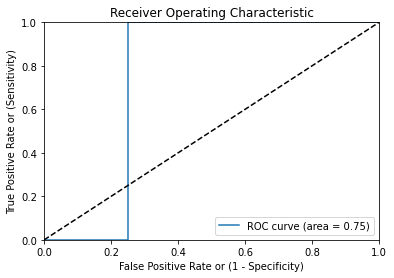

In [154]:
F.evaluate_model(Test_dataloader,resnet_trained_256)

In [155]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in tqdm_notebook(Test_dataloader,desc="Confusion_matrix"):
    inputs = inputs.to(torch.float)
    
    
    output = resnet_trained_256(inputs) # Feed Network
        

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth
        
confusion_matrix(y_true, y_pred)

Confusion_matrix:   0%|          | 0/1 [00:00<?, ?it/s]

array([[1, 3],
       [0, 2]])

# Training Resnet Pre_trained = True for K=256

In [156]:
model=F.ModifiedCNNT()
resnet_trained_256T=F.train_model(Training_dataloader,0.001,50,model)

Epoch [1/50] Loss: 0.7491
Epoch [2/50] Loss: 0.8012
Epoch [3/50] Loss: 0.7562
Epoch [4/50] Loss: 0.2012
Epoch [5/50] Loss: 0.0697
Epoch [6/50] Loss: 1.5096
Epoch [7/50] Loss: 0.1067
Epoch [8/50] Loss: 0.1272
Epoch [9/50] Loss: 0.1087
Epoch [10/50] Loss: 0.9995
Epoch [11/50] Loss: 0.1552
Epoch [12/50] Loss: 0.2059
Epoch [13/50] Loss: 0.1653
Epoch [14/50] Loss: 0.0920
Epoch [15/50] Loss: 1.0405
Epoch [16/50] Loss: 0.7710
Epoch [17/50] Loss: 0.2314
Epoch [18/50] Loss: 0.3079
Epoch [19/50] Loss: 0.3293
Epoch [20/50] Loss: 0.1486
Epoch [21/50] Loss: 0.8460
Epoch [22/50] Loss: 0.1101
Epoch [23/50] Loss: 0.4091
Epoch [24/50] Loss: 0.2364
Epoch [25/50] Loss: 0.1165
Epoch [26/50] Loss: 0.7818
Epoch [27/50] Loss: 0.1775
Epoch [28/50] Loss: 0.3380
Epoch [29/50] Loss: 0.2843
Epoch [30/50] Loss: 0.0605
Epoch [31/50] Loss: 0.2359
Epoch [32/50] Loss: 0.2780
Epoch [33/50] Loss: 0.0963
Epoch [34/50] Loss: 0.0509
Epoch [35/50] Loss: 0.1132
Epoch [36/50] Loss: 0.0273
Epoch [37/50] Loss: 0.0181
Epoch [38/

Accuracy: 50.00%
AUC: 0.62


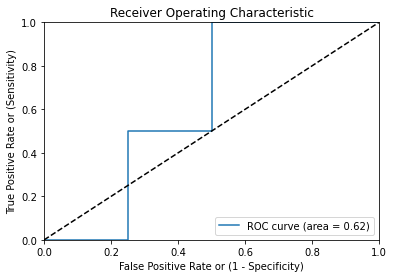

In [157]:
F.evaluate_model(Test_dataloader,resnet_trained_256T)

In [158]:
F.Confusion_matrix(Test_dataloader,resnet_trained_256T)

Confusion_matrix:   0%|          | 0/1 [00:00<?, ?it/s]

array([[2, 2],
       [1, 1]])

## Sampling ratio k=512 

- We now sample 512 cells from each patient

In [159]:
nk_tsne_512=F.tsne_2darrays(file_path_nkcell_train,df_1k_train,-66.39982239459924, 66.81470529543462,
                            -67.61723245056528, 71.01785596019363,100,512,drop)

In [160]:
nk_tsne_512_test=F.tsne_2darrays(file_path_nkcell_test,df_1k_train,-66.39982239459924, 66.81470529543462,
                            -67.61723245056528, 71.01785596019363,100,512,drop)

In [162]:
df_train_nk = pd.merge(nk_tsne_512, nk_label_train, on='fcs_file')
df_test_nk = pd.merge(nk_tsne_512_test, nk_label_test, on='fcs_file')

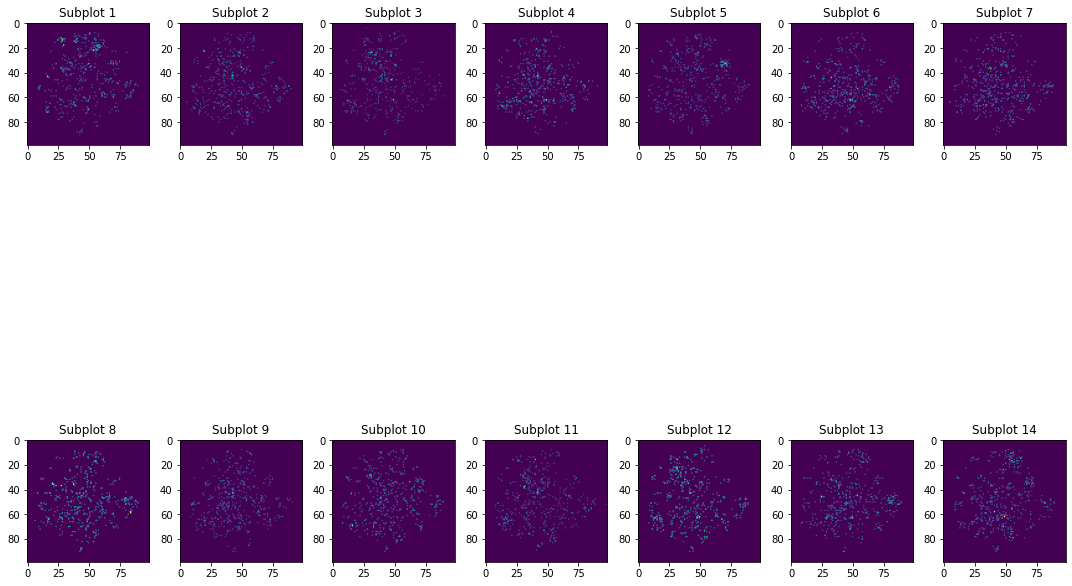

In [282]:
# Visualizing k=512
draw_subplots(nk_tsne_512)

# Training Resnet Pre_trained = True for K=256

In [163]:
# Creating dataset objects from the image data
Training_data=F.CustomDataset(df_train_nk)
Test_data=F.CustomDataset(df_test_nk)

# Convert the dataset objects to dataloaders
Training_dataloader= torch.utils.data.DataLoader(dataset=Training_data,batch_size=13,
                                                 shuffle=True)
Test_dataloader= torch.utils.data.DataLoader(dataset=Test_data,batch_size=6)

# Training simple CNN for K=512

In [164]:
model=F.CNN()
cnn_trained_512=F.train_model(Training_dataloader,0.001,50,model)

Epoch [1/50] Loss: 0.6367
Epoch [2/50] Loss: 1.3149
Epoch [3/50] Loss: 0.6704
Epoch [4/50] Loss: 0.5611
Epoch [5/50] Loss: 0.4948
Epoch [6/50] Loss: 0.4582
Epoch [7/50] Loss: 0.4529
Epoch [8/50] Loss: 0.3374
Epoch [9/50] Loss: 0.2517
Epoch [10/50] Loss: 0.2187
Epoch [11/50] Loss: 0.1682
Epoch [12/50] Loss: 0.2622
Epoch [13/50] Loss: 0.0700
Epoch [14/50] Loss: 0.1969
Epoch [15/50] Loss: 0.2439
Epoch [16/50] Loss: 0.0263
Epoch [17/50] Loss: 0.1561
Epoch [18/50] Loss: 0.1718
Epoch [19/50] Loss: 0.1971
Epoch [20/50] Loss: 0.0128
Epoch [21/50] Loss: 0.0410
Epoch [22/50] Loss: 0.4233
Epoch [23/50] Loss: 0.0490
Epoch [24/50] Loss: 0.0207
Epoch [25/50] Loss: 0.0210
Epoch [26/50] Loss: 0.0123
Epoch [27/50] Loss: 0.0439
Epoch [28/50] Loss: 0.0155
Epoch [29/50] Loss: 0.0126
Epoch [30/50] Loss: 0.0112
Epoch [31/50] Loss: 0.0086
Epoch [32/50] Loss: 0.0054
Epoch [33/50] Loss: 0.0030
Epoch [34/50] Loss: 0.0017
Epoch [35/50] Loss: 0.0011
Epoch [36/50] Loss: 0.0010
Epoch [37/50] Loss: 0.0010
Epoch [38/

Accuracy: 83.33%
AUC: 0.88


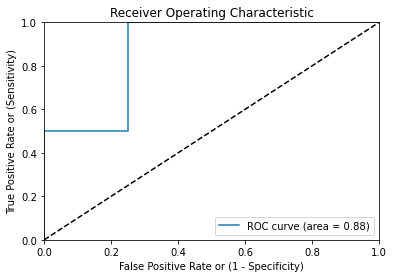

In [165]:
F.evaluate_model(Test_dataloader,cnn_trained_512)

In [166]:
F.Confusion_matrix(Test_dataloader,cnn_trained_512)

Confusion_matrix:   0%|          | 0/1 [00:00<?, ?it/s]

array([[4, 0],
       [1, 1]])

# Training Resnet Pre_trined = False for k=512

In [167]:
model=F.ModifiedCNN()
resnet_trained_512=F.train_model(Training_dataloader,0.001,50,model)

Epoch [1/50] Loss: 0.6432
Epoch [2/50] Loss: 1.2452
Epoch [3/50] Loss: 0.0906
Epoch [4/50] Loss: 1.2610
Epoch [5/50] Loss: 0.3397
Epoch [6/50] Loss: 0.0439
Epoch [7/50] Loss: 1.3024
Epoch [8/50] Loss: 0.0841
Epoch [9/50] Loss: 0.1026
Epoch [10/50] Loss: 0.4320
Epoch [11/50] Loss: 0.3034
Epoch [12/50] Loss: 0.0452
Epoch [13/50] Loss: 1.2538
Epoch [14/50] Loss: 0.8610
Epoch [15/50] Loss: 0.1590
Epoch [16/50] Loss: 0.2713
Epoch [17/50] Loss: 1.1977
Epoch [18/50] Loss: 0.2730
Epoch [19/50] Loss: 0.2203
Epoch [20/50] Loss: 0.8355
Epoch [21/50] Loss: 0.6061
Epoch [22/50] Loss: 0.2329
Epoch [23/50] Loss: 0.0695
Epoch [24/50] Loss: 0.2536
Epoch [25/50] Loss: 0.2358
Epoch [26/50] Loss: 0.0293
Epoch [27/50] Loss: 0.0251
Epoch [28/50] Loss: 0.0225
Epoch [29/50] Loss: 0.0145
Epoch [30/50] Loss: 0.1458
Epoch [31/50] Loss: 0.0160
Epoch [32/50] Loss: 0.0155
Epoch [33/50] Loss: 0.1021
Epoch [34/50] Loss: 0.0175
Epoch [35/50] Loss: 0.0203
Epoch [36/50] Loss: 0.0236
Epoch [37/50] Loss: 0.0174
Epoch [38/

Accuracy: 50.00%
AUC: 0.50


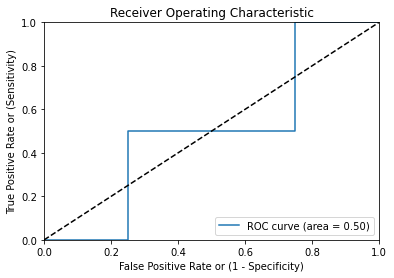

In [168]:
F.evaluate_model(Test_dataloader,resnet_trained_512)

In [169]:
F.Confusion_matrix(Test_dataloader,resnet_trained_512)

Confusion_matrix:   0%|          | 0/1 [00:00<?, ?it/s]

array([[1, 3],
       [0, 2]])

# Training Resnet Pre_trined = True for k=512

In [170]:
model=F.ModifiedCNNT()
resnet_trained_512T=F.train_model(Training_dataloader,0.001,50,model)

Epoch [1/50] Loss: 0.7723
Epoch [2/50] Loss: 0.7640
Epoch [3/50] Loss: 0.3489
Epoch [4/50] Loss: 0.1692
Epoch [5/50] Loss: 0.0604
Epoch [6/50] Loss: 0.0197
Epoch [7/50] Loss: 1.9724
Epoch [8/50] Loss: 0.0550
Epoch [9/50] Loss: 0.8987
Epoch [10/50] Loss: 0.3465
Epoch [11/50] Loss: 0.1087
Epoch [12/50] Loss: 0.0446
Epoch [13/50] Loss: 0.0218
Epoch [14/50] Loss: 1.9646
Epoch [15/50] Loss: 0.0388
Epoch [16/50] Loss: 1.0635
Epoch [17/50] Loss: 0.4912
Epoch [18/50] Loss: 0.6131
Epoch [19/50] Loss: 0.5291
Epoch [20/50] Loss: 0.4156
Epoch [21/50] Loss: 0.3365
Epoch [22/50] Loss: 0.2337
Epoch [23/50] Loss: 0.1275
Epoch [24/50] Loss: 0.0649
Epoch [25/50] Loss: 0.0374
Epoch [26/50] Loss: 1.5771
Epoch [27/50] Loss: 0.0467
Epoch [28/50] Loss: 0.9245
Epoch [29/50] Loss: 0.4675
Epoch [30/50] Loss: 0.6411
Epoch [31/50] Loss: 0.5620
Epoch [32/50] Loss: 0.3119
Epoch [33/50] Loss: 0.2178
Epoch [34/50] Loss: 0.1195
Epoch [35/50] Loss: 0.8428
Epoch [36/50] Loss: 0.4694
Epoch [37/50] Loss: 0.2161
Epoch [38/

Accuracy: 66.67%
AUC: 0.50


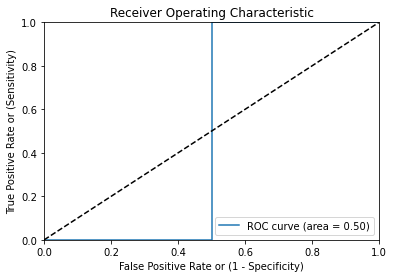

In [171]:
F.evaluate_model(Test_dataloader,resnet_trained_512T)

In [172]:
F.Confusion_matrix(Test_dataloader,resnet_trained_512T)

Confusion_matrix:   0%|          | 0/1 [00:00<?, ?it/s]

array([[4, 0],
       [2, 0]])

# For K=1024

In [173]:
nk_tsne_1024=F.tsne_2darrays(file_path_nkcell_train,df_1k_train,-66.39982239459924, 66.81470529543462,
                            -67.61723245056528, 71.01785596019363,100,1024,drop)

In [174]:
nk_tsne_1024_test=F.tsne_2darrays(file_path_nkcell_test,df_1k_train,-66.39982239459924, 66.81470529543462,
                            -67.61723245056528, 71.01785596019363,100,1024,drop)

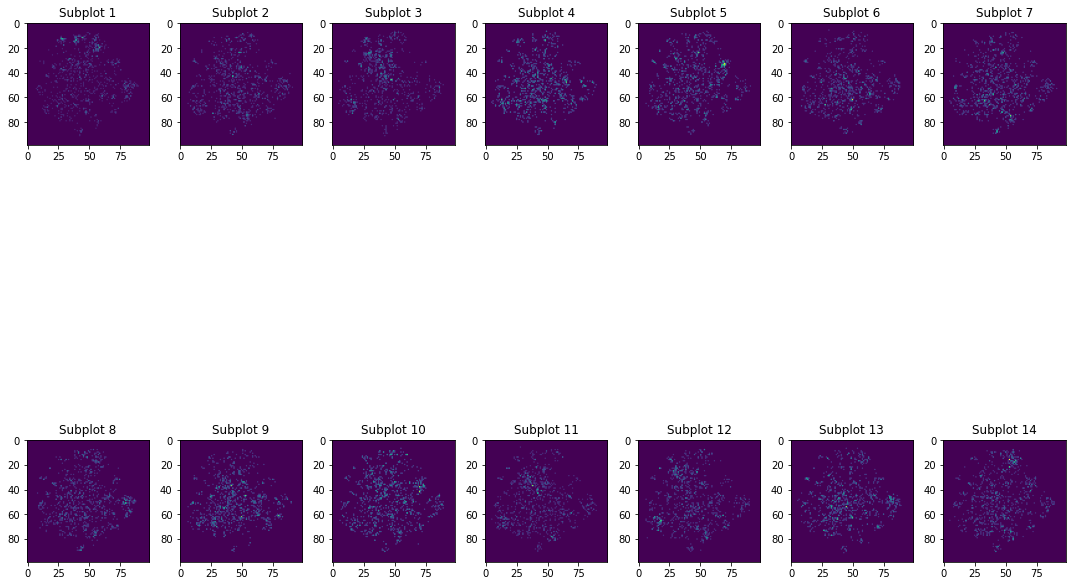

In [283]:
# visualizing K=1024
draw_subplots(nk_tsne_1024)

In [177]:
df_train_nk = pd.merge(nk_tsne_1024, nk_label_train, on='fcs_file')
df_test_nk = pd.merge(nk_tsne_1024_test, nk_label_test, on='fcs_file')

In [178]:
# Creating dataset objects from the image data
Training_data=F.CustomDataset(df_train_nk)
Test_data=F.CustomDataset(df_test_nk)

# Convert the dataset objects to dataloaders
Training_dataloader= torch.utils.data.DataLoader(dataset=Training_data,batch_size=13,
                                                 shuffle=True)
Test_dataloader= torch.utils.data.DataLoader(dataset=Test_data,batch_size=6)

# Training simple CNN for K=1024

In [179]:
model=F.CNN()
cnn_trained_1024=F.train_model(Training_dataloader,0.001,50,model)

Epoch [1/50] Loss: 0.6575
Epoch [2/50] Loss: 1.1724
Epoch [3/50] Loss: 0.7338
Epoch [4/50] Loss: 0.6539
Epoch [5/50] Loss: 0.3304
Epoch [6/50] Loss: 0.2736
Epoch [7/50] Loss: 0.3467
Epoch [8/50] Loss: 0.2994
Epoch [9/50] Loss: 0.2145
Epoch [10/50] Loss: 0.1275
Epoch [11/50] Loss: 0.1321
Epoch [12/50] Loss: 0.0561
Epoch [13/50] Loss: 0.0549
Epoch [14/50] Loss: 0.0352
Epoch [15/50] Loss: 0.0272
Epoch [16/50] Loss: 0.0189
Epoch [17/50] Loss: 0.0131
Epoch [18/50] Loss: 0.0075
Epoch [19/50] Loss: 0.0050
Epoch [20/50] Loss: 0.0124
Epoch [21/50] Loss: 0.0038
Epoch [22/50] Loss: 0.0031
Epoch [23/50] Loss: 0.0039
Epoch [24/50] Loss: 0.0047
Epoch [25/50] Loss: 0.0029
Epoch [26/50] Loss: 0.0017
Epoch [27/50] Loss: 0.0010
Epoch [28/50] Loss: 0.0015
Epoch [29/50] Loss: 0.0012
Epoch [30/50] Loss: 0.0010
Epoch [31/50] Loss: 0.0012
Epoch [32/50] Loss: 0.0012
Epoch [33/50] Loss: 0.0009
Epoch [34/50] Loss: 0.0016
Epoch [35/50] Loss: 0.0005
Epoch [36/50] Loss: 0.0004
Epoch [37/50] Loss: 0.0008
Epoch [38/

Accuracy: 83.33%
AUC: 1.00


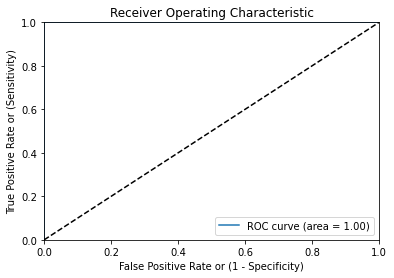

In [180]:
F.evaluate_model(Test_dataloader,cnn_trained_1024)

In [181]:
F.Confusion_matrix(Test_dataloader,cnn_trained_1024)

Confusion_matrix:   0%|          | 0/1 [00:00<?, ?it/s]

array([[3, 1],
       [0, 2]])

# Training resnet18 Pre_trained = False for K=1024

In [182]:
model=F.ModifiedCNN()
resnet_trained_1024=F.train_model(Training_dataloader,0.001,50,model)

Epoch [1/50] Loss: 0.8880
Epoch [2/50] Loss: 1.0153
Epoch [3/50] Loss: 0.5021
Epoch [4/50] Loss: 0.3867
Epoch [5/50] Loss: 0.1597
Epoch [6/50] Loss: 0.7778
Epoch [7/50] Loss: 0.0798
Epoch [8/50] Loss: 0.1329
Epoch [9/50] Loss: 0.8637
Epoch [10/50] Loss: 0.1661
Epoch [11/50] Loss: 0.0695
Epoch [12/50] Loss: 0.3074
Epoch [13/50] Loss: 0.5785
Epoch [14/50] Loss: 0.7448
Epoch [15/50] Loss: 0.1390
Epoch [16/50] Loss: 0.0227
Epoch [17/50] Loss: 0.0233
Epoch [18/50] Loss: 1.1645
Epoch [19/50] Loss: 1.7769
Epoch [20/50] Loss: 0.0339
Epoch [21/50] Loss: 0.0558
Epoch [22/50] Loss: 0.0374
Epoch [23/50] Loss: 0.0423
Epoch [24/50] Loss: 0.3634
Epoch [25/50] Loss: 0.1939
Epoch [26/50] Loss: 0.0212
Epoch [27/50] Loss: 0.0123
Epoch [28/50] Loss: 0.0183
Epoch [29/50] Loss: 0.0181
Epoch [30/50] Loss: 0.0744
Epoch [31/50] Loss: 0.1316
Epoch [32/50] Loss: 0.0718
Epoch [33/50] Loss: 0.0533
Epoch [34/50] Loss: 0.0338
Epoch [35/50] Loss: 0.0228
Epoch [36/50] Loss: 0.1123
Epoch [37/50] Loss: 0.0151
Epoch [38/

Accuracy: 66.67%
AUC: 0.75


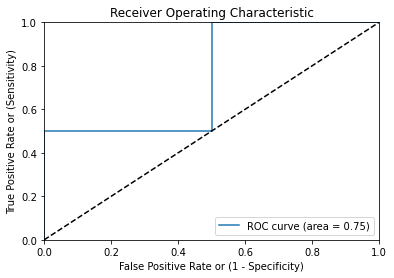

In [183]:
F.evaluate_model(Test_dataloader,resnet_trained_1024)

In [184]:
F.Confusion_matrix(Test_dataloader,resnet_trained_1024)

Confusion_matrix:   0%|          | 0/1 [00:00<?, ?it/s]

array([[4, 0],
       [2, 0]])

# Training resnet18 Pre_trained = True for k=1024

In [185]:
model=F.ModifiedCNNT()
resnet_trained_1024T=F.train_model(Training_dataloader,0.001,50,model)

Epoch [1/50] Loss: 0.7513
Epoch [2/50] Loss: 0.2402
Epoch [3/50] Loss: 1.5484
Epoch [4/50] Loss: 0.3679
Epoch [5/50] Loss: 0.7589
Epoch [6/50] Loss: 0.4766
Epoch [7/50] Loss: 0.6400
Epoch [8/50] Loss: 0.3901
Epoch [9/50] Loss: 0.2949
Epoch [10/50] Loss: 0.1629
Epoch [11/50] Loss: 0.9316
Epoch [12/50] Loss: 0.7912
Epoch [13/50] Loss: 0.3018
Epoch [14/50] Loss: 0.3160
Epoch [15/50] Loss: 0.5223
Epoch [16/50] Loss: 0.1983
Epoch [17/50] Loss: 0.1551
Epoch [18/50] Loss: 0.1097
Epoch [19/50] Loss: 0.0682
Epoch [20/50] Loss: 0.0434
Epoch [21/50] Loss: 1.3427
Epoch [22/50] Loss: 0.0481
Epoch [23/50] Loss: 0.7807
Epoch [24/50] Loss: 0.4214
Epoch [25/50] Loss: 0.1689
Epoch [26/50] Loss: 0.9610
Epoch [27/50] Loss: 0.8721
Epoch [28/50] Loss: 0.4667
Epoch [29/50] Loss: 0.2347
Epoch [30/50] Loss: 0.1421
Epoch [31/50] Loss: 0.0581
Epoch [32/50] Loss: 0.0289
Epoch [33/50] Loss: 1.7531
Epoch [34/50] Loss: 0.0367
Epoch [35/50] Loss: 1.3338
Epoch [36/50] Loss: 0.6043
Epoch [37/50] Loss: 0.2175
Epoch [38/

Accuracy: 33.33%
AUC: 0.50


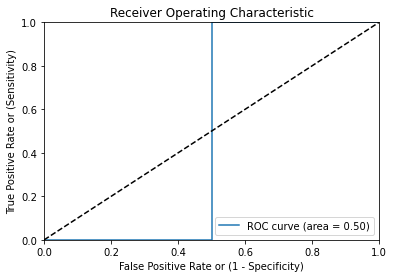

In [188]:
F.evaluate_model(Test_dataloader,resnet_trained_1024T)

In [189]:
F.Confusion_matrix(Test_dataloader,resnet_trained_1024T)

Confusion_matrix:   0%|          | 0/1 [00:00<?, ?it/s]

array([[0, 4],
       [0, 2]])

# Sampling all cells 

In [275]:
# All cells
nk_tsne_all=F.tsne_2darrays(file_path_nkcell_train,df_1k_train,-73.83141165532892, 85.80558945297798, 
                            -69.62740527003547, 81.93167451181114,100,column=drop)


nk_tsne_all_test=F.tsne_2darrays(file_path_nkcell_test,df_1k_train,-73.83141165532892, 85.80558945297798,
                                 -69.62740527003547, 81.93167451181114,100,column=drop)

In [276]:
df_train_nk_all = pd.merge(nk_tsne_all, nk_label_train, on='fcs_file')
df_test_nk_all = pd.merge(nk_tsne_all_test, nk_label_test, on='fcs_file')

In [277]:
# Creating dataset objects from the image data
Training_data_all=F.CustomDataset(df_train_nk_all)
Test_data_all=F.CustomDataset(df_test_nk_all)

# Convert the dataset objects to dataloaders
Training_dataloader_all= torch.utils.data.DataLoader(dataset=Training_data_all,batch_size=13,
                                                 shuffle=True)
Test_dataloader_all= torch.utils.data.DataLoader(dataset=Test_data_all,batch_size=6)

In [278]:
model=F.CNN()
cnn_trained_all=F.train_model(Training_dataloader_all,0.001,50,model)

Epoch [1/50] Loss: 3.9979
Epoch [2/50] Loss: 0.2940
Epoch [3/50] Loss: 1.8191
Epoch [4/50] Loss: 1.1565
Epoch [5/50] Loss: 1.1940
Epoch [6/50] Loss: 0.6302
Epoch [7/50] Loss: 0.5617
Epoch [8/50] Loss: 0.5850
Epoch [9/50] Loss: 0.5615
Epoch [10/50] Loss: 0.4594
Epoch [11/50] Loss: 0.4729
Epoch [12/50] Loss: 0.2331
Epoch [13/50] Loss: 0.2911
Epoch [14/50] Loss: 0.3699
Epoch [15/50] Loss: 0.1104
Epoch [16/50] Loss: 0.1099
Epoch [17/50] Loss: 0.0901
Epoch [18/50] Loss: 0.1058
Epoch [19/50] Loss: 0.1003
Epoch [20/50] Loss: 0.0482
Epoch [21/50] Loss: 0.0262
Epoch [22/50] Loss: 0.0132
Epoch [23/50] Loss: 0.0112
Epoch [24/50] Loss: 0.0073
Epoch [25/50] Loss: 0.0070
Epoch [26/50] Loss: 0.0043
Epoch [27/50] Loss: 0.0046
Epoch [28/50] Loss: 0.0019
Epoch [29/50] Loss: 0.0036
Epoch [30/50] Loss: 0.0015
Epoch [31/50] Loss: 0.0015
Epoch [32/50] Loss: 0.0012
Epoch [33/50] Loss: 0.0015
Epoch [34/50] Loss: 0.0012
Epoch [35/50] Loss: 0.0012
Epoch [36/50] Loss: 0.0012
Epoch [37/50] Loss: 0.0004
Epoch [38/

Accuracy: 100.00%
AUC: 1.00


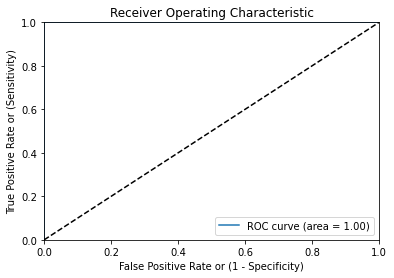

In [279]:
F.evaluate_model(Test_dataloader_all,cnn_trained_all)

In [281]:
F.Confusion_matrix(Test_dataloader_all,cnn_trained_all)

Confusion_matrix:   0%|          | 0/1 [00:00<?, ?it/s]

array([[4, 0],
       [0, 2]])

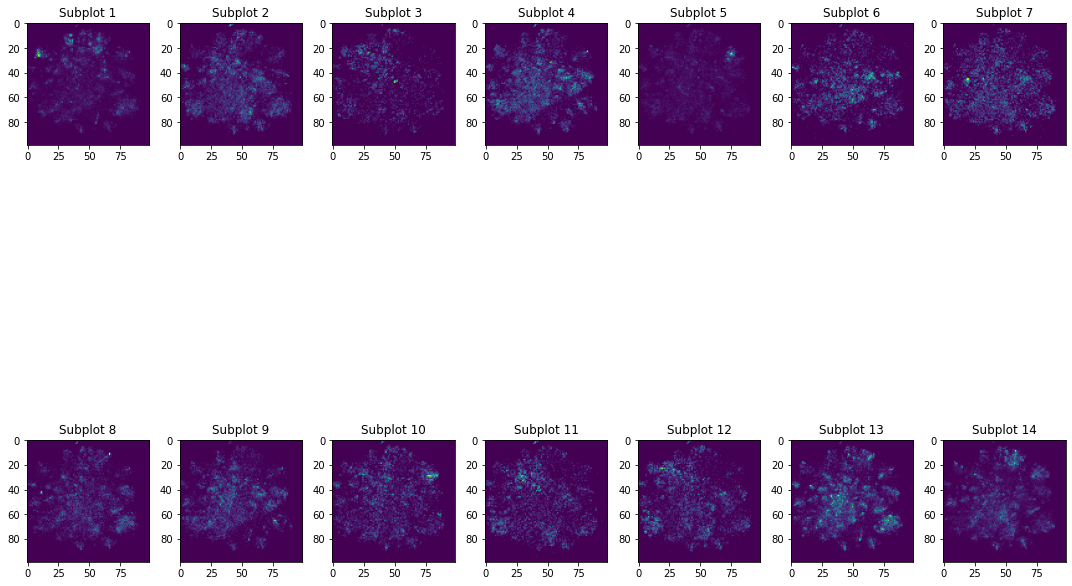

In [284]:
# Visualize K=all
draw_subplots(nk_tsne_all)